In [2]:
import torch
import matplotlib.pyplot as plt
import random
import pandas as pd

from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler

from torch.utils.data import random_split
from torch.optim.lr_scheduler import StepLR
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from numpy import vstack
from numpy import argmax

import torch.nn.functional as F
import torch.nn as nn
import numpy as np

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('CUDA:', torch.cuda.is_available(), ' Use << {} >>'.format(device.upper()))
print('PyTorch Version:', torch.__version__)

CUDA: True  Use << CUDA >>
PyTorch Version: 1.7.1+cu110


In [4]:
class CSVDataset(Dataset):
    def __init__(self, file_name):

        dataframe = pd.read_csv(file_name)
        x = dataframe.iloc[:,0:9].values # inputs
        y = dataframe.iloc[:, 9].values # labels
        z = dataframe.iloc[:, 10:15].values # details
        
        self.x = x
        self.y = y
        self.z = z
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx): 
        return self.x[idx], self.y[idx], self.z[idx]

In [5]:
class TrainDataset(Dataset):
    def __init__(self, file_name):

        dataframe = pd.read_csv(file_name)
        
        x = dataframe.iloc[:,0:9].values # inputs
        y = dataframe.iloc[:, 9].values # labels
        y = (y-100)/100 # labels must start at 0 so adjust this to your data
        z = dataframe.iloc[:, 10:15].values # details
        
        #converting to torch tensors
        self.x = torch.tensor(x, dtype=torch.float32) 
        self.y = torch.tensor(y, dtype=torch.int32)
        self.z = torch.tensor(z, dtype=torch.int32)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx): 
        return self.x[idx], self.y[idx], self.z[idx]

In [6]:
import os
import csv
import numpy as np

from sklearn.model_selection import train_test_split

os.chdir("C:\\") # adjust this to your file directory
input_data = CSVDataset('.csv') # adjust this to your file name



print("\nTotal Data Length:", len(input_data))


X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(input_data.x, input_data.y, input_data.z, test_size=0.3, shuffle = True, random_state=42)
X_val, X_test, y_val, y_test, z_val, z_test = train_test_split(X_test, y_test, z_test, test_size=0.5, shuffle = True, random_state = 3)

print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)


torch.set_printoptions(precision=10)

# Save train data set
f = open('.csv','w', newline='')
wr = csv.writer(f)

for i in range(len(y_train)):
    wr.writerow([(X_train[i][0]/100)-5.5, X_train[i][1], X_train[i][2], X_train[i][3], X_train[i][4], X_train[i][5], X_train[i][6], X_train[i][7], X_train[i][8], y_train[i] , z_train[i][0], z_train[i][1], z_train[i][2], z_train[i][3], z_train[i][4]])
    # you can change the data
    
f.close()

# Save validation data set
f = open('.csv','w', newline='')
wr = csv.writer(f)

for i in range(len(y_val)):
    wr.writerow([(X_val[i][0]/100)-5.5, X_val[i][1], X_val[i][2], X_val[i][3], X_val[i][4], X_val[i][5], X_val[i][6], X_val[i][7], X_val[i][8], y_val[i], z_val[i][0], z_val[i][1], z_val[i][2], z_val[i][3], z_val[i][4]])
    
f.close()



# Save test data set
f = open('.csv','w', newline='')
wr = csv.writer(f)

for i in range(len(y_test)):
    wr.writerow([(X_test[i][0]/100)-5.5, X_test[i][1], X_test[i][2], X_test[i][3], X_test[i][4], X_test[i][5], X_test[i][6], X_test[i][7], X_test[i][8], y_test[i], z_test[i][0], z_test[i][1], z_test[i][2], z_test[i][3], z_test[i][4]])
    
f.close()



Data looks like
[[ 2.00000000e+02  4.78722035e+00 -7.16397610e-02 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 2.00000000e+02  4.26964719e+00  2.12739533e-01 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 2.00000000e+02  5.21402244e+00 -2.63581875e-01 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 ...
 [ 3.00000000e+02  4.98698533e+00  3.36784830e-02 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 4.00000000e+02  4.48742140e+00  6.35409590e-02 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 2.00000000e+02  4.69049467e+00  1.32605150e-02 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]
[200 200 200 ... 300 400 200]

Total Data Length: 18261
X_train shape: (12782, 9)
X_val shape: (2739, 9)
X_test shape: (2740, 9)
y_train shape: (12782,)
y_val shape: (2739,)
y_test shape: (2740,)


In [7]:
class MLP(nn.Module):
    def __init__(self, n_input):
        super(MLP, self).__init__()
        
        self.act = ReLU()
        
        self.hidden1 = Linear(n_input, 100).to(device)
        
        self.hidden2 = Linear(100, 300).to(device)
        
        self.hidden3 = Linear(300, 100).to(device)
        
        self.hiddenfinal = Linear(100, 10).to(device)

    # this example has 3 hidden layers
    def forward(self, X):
        
        X = self.hidden1(X)
        X = self.act(X)
        
        X = self.hidden2(X)
        X = self.act(X)
        
        X = self.hidden3(X)
        X = self.act(X)
        
        X = self.hiddenfinal(X)
        
        return X

In [8]:
epoches = 100
batch_size = 40
learning_rate = 0.001

In [9]:
os.chdir("C:\\")
trainset = TrainDataset('.csv') # adjust this to your file name
valset = TrainDataset('.csv') # adjust this to your file name
testset = TrainDataset('.csv') # adjust this to your file name


trainLoader = torch.utils.data.DataLoader(trainset, batch_size, shuffle = True)
valLoader = torch.utils.data.DataLoader(valset, batch_size, shuffle = True)
testLoader = torch.utils.data.DataLoader(testset, batch_size, shuffle = True)

model = MLP(9)
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.8)
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[], 'test_loss':[], 'test_acc':[]}

In [8]:
def accuracy_check_for_batch(labels, preds, batch_size):
    total_acc = 0
    for i in range(batch_size):        
        total_acc += accuracy_check(labels[i], preds[i])
    return total_acc/batch_size

In [9]:
def get_loss_train(model, trainloader, criterion, device):
    model.eval()
    total_acc = 0
    total_loss = 0
    
    for batch, (inputs, labels, details) in enumerate(trainLoader):
        with torch.no_grad():
            inputs = inputs.to(device)
            labels = labels.to(device = device, dtype = torch.int64)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            preds = torch.argmax(outputs, dim=1)
            acc = accuracy_check_for_batch(labels, preds, inputs.size()[0])
            total_acc += acc
            total_loss += loss.cpu().item()
        
    return total_acc/(batch+1), total_loss/(batch+1)

In [10]:
def accuracy_check(label, pred):
    ims = [label, pred]
    np_ims = []
    for item in ims:
        item = item.cpu().numpy()
        np_ims.append(item)
    compare = np.equal(np_ims[0], np_ims[1])
    accuracy = np.sum(compare)
    return accuracy / len(np_ims[0].flatten())

In [11]:
def train_model(model, trainLoader, criterion, optimizer, scheduler, device):
    model.train()
    
    for i, (inputs, labels, details) in enumerate(trainLoader): # for one batch
        current_loss = 0.0
        
        
        inputs = inputs.to(device)
        labels = labels.to(device=device, dtype=torch.int64)
        
        
        criterion = criterion.cuda()
        outputs = model(inputs)
        
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()

In [12]:
def val_model(model, valLoader, criterion, device):
    total_val_loss=0
    total_val_acc=0
    for batch, (inputs, labels, details) in enumerate(valLoader): # for one batch
            with torch.no_grad():
                inputs = inputs.to(device)
                labels = labels.to(device=device, dtype=torch.int64)
        
                outputs = model(inputs)
                loss = criterion(outputs, labels)
        
                preds = torch.argmax(outputs, dim=1)
                
                acc = accuracy_check_for_batch(labels, preds, inputs.size()[0])
                total_val_acc += acc
                total_val_loss += loss.cpu().item()
                
            
    
                
                
    return total_val_acc/(batch+1), total_val_loss/(batch+1)

In [13]:
def print_pred(model, finalLoader, device):
    f = open('.csv','w', newline='') # adjust this to your file name
    for i, (inputs, labels, details) in enumerate(finalLoader):
        with torch.no_grad():
                inputs = inputs.to(device)
                labels = labels.to(device=device, dtype=torch.int64)
                
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                
                wr = csv.writer(f)
                wr.writerow([inputs[0][0], inputs[0][1], inputs[0][2], inputs[0][3], int(inputs[0][4]), int(inputs[0][5]), int(inputs[0][6]), int(inputs[0][7]), int(inputs[0][8]),  int(labels[0]), int(details[0][0]), int(details[0][1]), int(details[0][2]), int(details[0][3]), int(details[0][4]) ,int(preds[0])])
            
    f.close()

In [17]:
print("Training\n")
for epoch in range(epoches):
    
    train_model(model, trainLoader, criterion, optimizer, scheduler, device)
    train_acc, train_loss = get_loss_train(model, trainLoader, criterion, device)
    print("epoch : {:<5} train loss : {:<15.5f} train acc : {:<10.5f}".format(epoch+1, train_loss, train_acc))
    
    val_acc, val_loss = val_model(model, valLoader, criterion, device)
    print("epoch : {:<5} val loss : {:<17.5f} val acc : {:<10.5f}".format(epoch+1, val_loss, val_acc))

#     you can print the test history through this code
#     test_acc, test_loss = val_model(model, testLoader, criterion, device)
#     print("epoch : {:<5} test loss : {:<16.5f} test acc : {:<10.5f}\n".format(epoch+1, test_loss, test_acc))

    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    
    scheduler.step()
    
    torch.save(model.state_dict(), './model'+str(epoch+1)+'.pth')
    
    

    
print("\nTraining Finished")

Training

epoch : 1     train loss : 0.23781         train acc : 0.92563   
epoch : 1     val loss : 0.24461           val acc : 0.92520   
epoch : 1     test loss : 0.21599          test acc : 0.93478   

epoch : 2     train loss : 0.22271         train acc : 0.93352   
epoch : 2     val loss : 0.21609           val acc : 0.93297   
epoch : 2     test loss : 0.20254          test acc : 0.93514   

epoch : 3     train loss : 0.21722         train acc : 0.93360   
epoch : 3     val loss : 0.21364           val acc : 0.93506   
epoch : 3     test loss : 0.19354          test acc : 0.94167   

epoch : 4     train loss : 0.20393         train acc : 0.92791   
epoch : 4     val loss : 0.20664           val acc : 0.93035   
epoch : 4     test loss : 0.18891          test acc : 0.93514   

epoch : 5     train loss : 0.19348         train acc : 0.93416   
epoch : 5     val loss : 0.19963           val acc : 0.93571   
epoch : 5     test loss : 0.18336          test acc : 0.93902   

epoch : 6 

epoch : 43    train loss : 0.14405         train acc : 0.94805   
epoch : 43    val loss : 0.17657           val acc : 0.94014   
epoch : 43    test loss : 0.15016          test acc : 0.94561   

epoch : 44    train loss : 0.14152         train acc : 0.94821   
epoch : 44    val loss : 0.17739           val acc : 0.94143   
epoch : 44    test loss : 0.15447          test acc : 0.94518   

epoch : 45    train loss : 0.14136         train acc : 0.94907   
epoch : 45    val loss : 0.17873           val acc : 0.94223   
epoch : 45    test loss : 0.15646          test acc : 0.94920   

epoch : 46    train loss : 0.14061         train acc : 0.94852   
epoch : 46    val loss : 0.17683           val acc : 0.94159   
epoch : 46    test loss : 0.15635          test acc : 0.94268   

epoch : 47    train loss : 0.14903         train acc : 0.94502   
epoch : 47    val loss : 0.18753           val acc : 0.93535   
epoch : 47    test loss : 0.16149          test acc : 0.94264   

epoch : 48    train 

epoch : 85    train loss : 0.12485         train acc : 0.95501   
epoch : 85    val loss : 0.18914           val acc : 0.94275   
epoch : 85    test loss : 0.15913          test acc : 0.94855   

epoch : 86    train loss : 0.12410         train acc : 0.95493   
epoch : 86    val loss : 0.19080           val acc : 0.94086   
epoch : 86    test loss : 0.15932          test acc : 0.94743   

epoch : 87    train loss : 0.12482         train acc : 0.95416   
epoch : 87    val loss : 0.19084           val acc : 0.94340   
epoch : 87    test loss : 0.15672          test acc : 0.95000   

epoch : 88    train loss : 0.12572         train acc : 0.95359   
epoch : 88    val loss : 0.19487           val acc : 0.93977   
epoch : 88    test loss : 0.16012          test acc : 0.94670   

epoch : 89    train loss : 0.12482         train acc : 0.95447   
epoch : 89    val loss : 0.19297           val acc : 0.93969   
epoch : 89    test loss : 0.15822          test acc : 0.94811   

epoch : 90    train 

In [15]:
PATH = 'model.pth' # adjust this to your saved model

model = MLP(9)
model.load_state_dict(torch.load(PATH))
model.eval()

MLP(
  (act): ReLU()
  (hidden1): Linear(in_features=9, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=300, bias=True)
  (hidden3): Linear(in_features=300, out_features=100, bias=True)
  (hiddenfinal): Linear(in_features=100, out_features=10, bias=True)
)

In [24]:
os.chdir("C:\\") # adjust this to your file directory
finalset = TrainDataset('.csv') # adjust this to your file name
finalLoader = torch.utils.data.DataLoader(finalset, batch_size=1, shuffle = False)

print_pred(model, finalLoader, device)

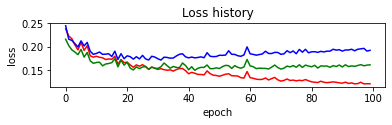

Text(0, 0.5, 'accuracy')

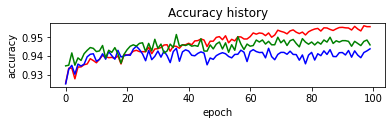

In [21]:
import matplotlib.pyplot as plt

plt.subplot(3,1,1)
plt.plot(range(epoch+1), history['train_loss'], label='Loss', color='red')
plt.plot(range(epoch+1), history['val_loss'], label='Loss', color='blue')
# you can plot the test loss history through this code
# plt.plot(range(epoch+1), history['test_loss'], label='Loss', color='green')

plt.title('Loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.subplot(3,1,2)
plt.plot(range(epoch+1), history['train_acc'], label='Accuracy', color='red')
plt.plot(range(epoch+1), history['val_acc'], label='Accuracy', color='blue')
# you can plot the test accuracy history through this code
# plt.plot(range(epoch+1), history['test_acc'], label='Accuracy', color='green')

plt.title('Accuracy history')
plt.xlabel('epoch')
plt.ylabel('accuracy')